In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib 

In [2]:
DATA = "../preprocessing/standardized_data.csv"
data = pd.read_csv(DATA,header=0)

# Gender Misclassification

In [3]:
def gender_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been gender misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the ground truth or the result from the API is "unsure", no misclassification
        if gt[i] == 0 or prediction[i] == 0: 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [4]:
misclass = {}
misclass["Clarifai"] = gender_misclassification(data["Gender"], data["clarifai_gender"])
misclass["Microsoft"] = gender_misclassification(data["Gender"], data["microsoft_gender"])
misclass["Amazon"] = gender_misclassification(data["Gender"], data["amazon_gender"])
misclass["Face++"] = gender_misclassification(data["Gender"], data["face++_gender"])

In [5]:
# Defining masks 
from_cfd = (data["Origin"] == "CFD")
from_nimstim = (data["Origin"] == "NimStim")
from_airbnb = (data["Origin"] == "AirBnb")
from_ai = (data["Origin"] == "AI")

# And the dataset sizes
n_cfd = sum(from_cfd)
n_nimstim = sum(from_nimstim)
n_airbnb = sum(from_airbnb)
n_ai = sum(from_ai)

datasets = {
    # Name --> (Mask, Size) for each dataset
    "CFD" : (from_cfd, n_cfd), 
    "NimStim" : (from_nimstim, n_nimstim), 
    "AirBnb" : (from_airbnb, n_airbnb), 
    "AI" : (from_ai, n_ai)
}

In [6]:
# Recall the different data sets' sizes: 
pd.DataFrame([len(data[data["Origin"] == ds]) for ds in datasets], index=datasets.keys(), columns=["Number of entries"])

,Number of entries
CFD,1207
NimStim,673
AirBnb,549
AI,248


In [7]:
misclass_rates = [[None for dataset in range(4)] for api in range(5)] 

for i, api in enumerate(misclass): 
    sum_for_api = 0
    for j, dataset in enumerate(datasets): 
        mask, n = datasets[dataset]
        misclass_rates[j][i] = sum(misclass[api][mask])/n
        sum_for_api += sum(misclass[api][mask])
    misclass_rates[4][i] = sum_for_api/len(data)

In [8]:
misclass_numbers = [[None for dataset in range(4)] for api in range(5)] 

for i, api in enumerate(misclass): 
    sum_for_api = 0
    for j, dataset in enumerate(datasets): 
        mask, n = datasets[dataset]
        misclass_numbers[j][i] = sum(misclass[api][mask])
        sum_for_api += sum(misclass[api][mask])
    misclass_numbers[4][i] = sum_for_api


In [9]:
misclass_rates_table = pd.DataFrame(misclass_rates, 
                                    columns=misclass.keys(), 
                                    index=list(datasets.keys()) + ['OVERALL'])

In [10]:
misclass_numbers_table = pd.DataFrame(misclass_numbers, 
                                    columns=misclass.keys() , 
                                    index=list(datasets.keys()) + ["OVERALL"])

In [11]:
display(misclass_numbers_table)
display(misclass_rates_table)

,Clarifai,Microsoft,Amazon,Face++
CFD,152.0,3.0,36.0,82.0
NimStim,88.0,0.0,6.0,31.0
AirBnb,45.0,6.0,18.0,20.0
AI,49.0,38.0,39.0,35.0
OVERALL,334.0,47.0,99.0,168.0


,Clarifai,Microsoft,Amazon,Face++
CFD,0.125932,0.002486,0.029826,0.067937
NimStim,0.130758,0.000000,0.008915,0.046062
AirBnb,0.081967,0.010929,0.032787,0.036430
AI,0.197581,0.153226,0.157258,0.141129
OVERALL,0.124767,0.017557,0.036982,0.062757


# Race Misclassification

In [12]:
def race_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been race misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the subjects is within a cornercase group or the prediction has outputed "not sure", then 
        # no misclassification
        if gt[i] in [0,5] or prediction[i] == 0 : 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [13]:
clarifai_race_misclass = race_misclassification(data["Race"], data["clarifai_race"])
# Creating a mask
is_race_misclass = [x == 1 for x in clarifai_race_misclass]

In [14]:
# Overall number of misclassifications
print(sum(is_race_misclass))
# Overall rate of misclassifications 
print(sum(is_race_misclass)/len(data))

384
0.14344415390362347


In [15]:
misclassed_data = data[is_race_misclass]
misclassed_race_numbers = {name: len(misclassed_data[misclassed_data["Origin"] == name]) for name in datasets.keys()}

In [17]:
pd.DataFrame(misclassed_race_numbers.values(), index=misclassed_race_numbers.keys(), columns=["Number of misclassifications"])

,Number of misclassifications
CFD,168
NimStim,52
AirBnb,99
AI,65


In [18]:
rates = [misclassed_race_numbers[name]/len(data[data["Origin"] == name]) for name in datasets.keys()]

In [19]:
rates

[0.1391880695940348,
 0.07726597325408618,
 0.18032786885245902,
 0.2620967741935484]

In [20]:
race_accuracy_table = pd.DataFrame([misclassed_race_numbers.values(), rates], 
             index=["Number of misclassifications", "Misclassification rate"], 
             columns=datasets.keys()
            )

In [21]:
race_accuracy_table

,CFD,NimStim,AirBnb,AI
Number of misclassifications,168.000000,52.000000,99.000000,65.000000
Misclassification rate,0.139188,0.077266,0.180328,0.262097


# Age Misclassification 

### Approach 1 - offset from the true value

In [22]:
print("Average non-absolute difference")
print("Clarifai", 
sum((data["clarifai_age"] - data["Age"]))/len(data))
print("Microsoft", 
sum((data["microsoft_age"] - data["Age"]))/len(data))
print("Amazon", 
sum((data["amazon_age_average"] - data["Age"]))/len(data)) 
print("Face++", 
sum((data["face++_age"] - data["Age"]))/len(data))

Average non-absolute difference
Clarifai 7.721703399327605
Microsoft 0.3522599925289503
Amazon 2.249346283152783
Face++ 7.372805379155771


In [23]:
sum((data["Age"] - data["microsoft_age"]))/len(data)

-0.3522599925289503

In [24]:
sum((data["Age"] - data["face++_age"]))/len(data)

-7.372805379155771

In [25]:
sum((data["Age"] - data["clarifai_age"]))/len(data)

-7.721703399327605

In [26]:
print("Average age error")

print("Clarifai", 
sum(abs(data["Age"] - data["clarifai_age"]))/len(data)) 

print("Microsoft",
sum(abs(data["Age"] - data["microsoft_age"]))/len(data)) 

print("Amazon", 
sum(abs(data["Age"] - data["amazon_age_average"]))/len(data)) 

print("Face++", 
sum(abs(data["Age"] - data["face++_age"]))/len(data)) 

Average age error
Clarifai 8.934254762794172
Microsoft 3.8203212551363466
Amazon 5.370003735524842
Face++ 8.606275681733283


In [27]:
def add_noise(vals, n): 
    return [val + np.random.normal(0, n) for val in vals]

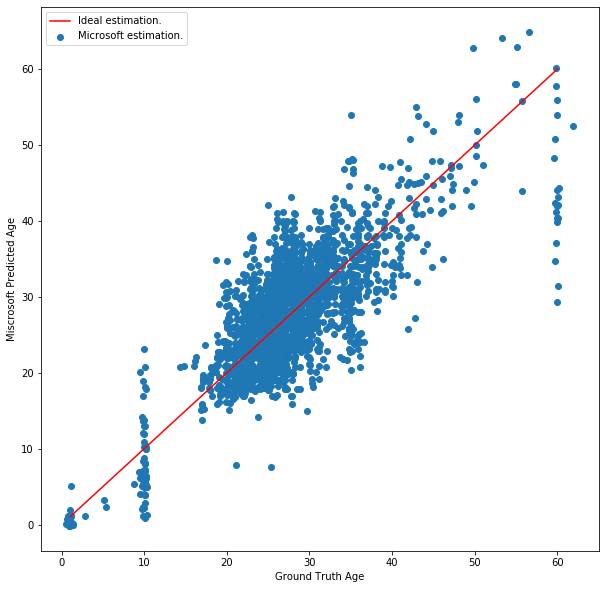

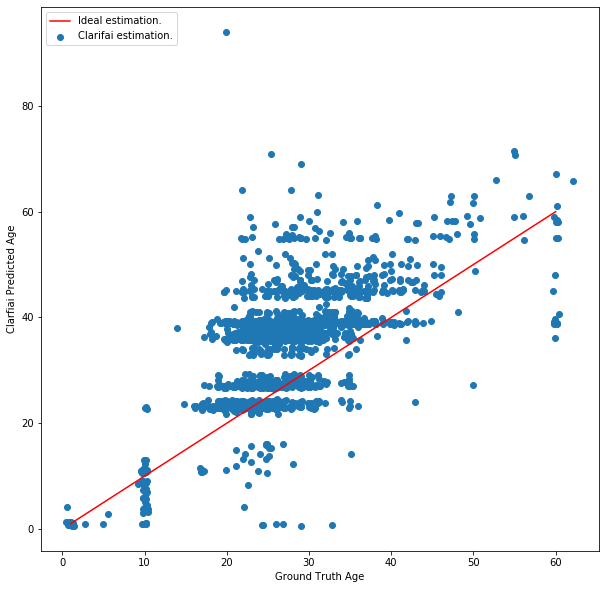

In [28]:
NOISE = 0.2

plt.figure(figsize=(10, 10))
plt.scatter(add_noise(data["Age"], NOISE), add_noise(data["microsoft_age"], NOISE), label="Microsoft estimation.")
plt.plot([1,60], [1,60], 'r', label="Ideal estimation.")
plt.xlabel("Ground Truth Age")
plt.ylabel("Miscrosoft Predicted Age")
plt.legend()
#plt.savefig('ms_age.svg', format='svg', dpi=1200)
plt.show()


plt.figure(figsize=(10, 10))
plt.scatter(add_noise(data["Age"], NOISE), add_noise(data["clarifai_age"], NOISE), label="Clarifai estimation.")
plt.plot([1,60], [1,60], 'r', label="Ideal estimation.")
plt.xlabel("Ground Truth Age")
plt.ylabel("Clarfiai Predicted Age")
plt.legend(loc="upper left")
#plt.savefig('clarifai_age.svg', format='svg', dpi=1200)
plt.show()

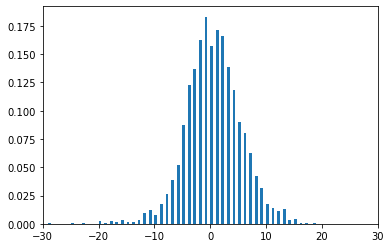

In [29]:
plt.hist(data["microsoft_age"] - data["Age"], bins=100, density=True)
plt.xlim(-30,30)
plt.show()

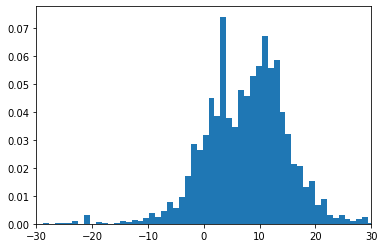

In [30]:
plt.hist(data["clarifai_age"] - data["Age"], bins=100, density=True)
plt.xlim(-30,30)
plt.show()

### Approach 2 - custom definition of misclassification

In [31]:
def age_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been age misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        tolerance = 0 
        # If the subject is a child, tolerance interval equals 5
        if gt[i] <= 10: 
            tolerance = 5
        # For teenagers and pre-young-adults, tolerance is 10
        elif gt[i] <= 25: 
            tolerance = 10
        # For the rest of the population, tolerance is 15
        else: 
            tolerance = 15
            
        if gt[i] - tolerance <= prediction[i] <= gt[i] + tolerance: 
            result[i] = 0
        else: 
            result[i] = 1
    return result

In [32]:
sum(age_misclassification(data["Age"], data["microsoft_age"]))/len(data)

0.022039596563317145

In [33]:
sum(age_misclassification(data["Age"], data["amazon_age_average"]))/len(data)

0.07433694434067986

In [34]:
sum(age_misclassification(data["Age"], data["face++_age"]))/len(data)

0.22861412028389988

In [35]:
sum(age_misclassification(data["Age"], data["clarifai_age"]))/len(data)

0.24691819200597684

In [36]:
age_misclass = {}
age_misclass["Clarifai"] = age_misclassification(data["Age"], data["clarifai_age"])
age_misclass["Microsoft"] = age_misclassification(data["Age"], data["microsoft_age"])
age_misclass["Amazon"] = age_misclassification(data["Age"], data["amazon_age_average"])
age_misclass["Face++"] = age_misclassification(data["Age"], data["face++_age"])

In [37]:
age_misclass_rates = [[None for dataset in range(4)] for api in range(5)] 

for i, api in enumerate(age_misclass): 
    sum_for_api = 0
    for j, dataset in enumerate(datasets): 
        mask, n = datasets[dataset]
        age_misclass_rates[j][i] = (100 * sum(age_misclass[api][mask])/n)
        sum_for_api += sum(age_misclass[api][mask])
    age_misclass_rates[4][i] = (100 * sum_for_api/len(data))

In [38]:
age_misclass_numbers = [[None for dataset in range(4)] for api in range(5)] 

for i, api in enumerate(age_misclass): 
    sum_for_api = 0
    for j, dataset in enumerate(datasets): 
        mask, n = datasets[dataset]
        age_misclass_numbers[j][i] = sum(age_misclass[api][mask])
        sum_for_api += sum(age_misclass[api][mask])
    age_misclass_numbers[4][i] = sum_for_api

In [39]:
age_misclass_rates_table = pd.DataFrame(age_misclass_rates, 
                                    columns=age_misclass.keys(), 
                                    index=list(datasets.keys()) + ['OVERALL'])

In [40]:
age_misclass_numbers_table = pd.DataFrame(age_misclass_numbers, 
                                    columns=age_misclass.keys(), 
                                    index=list(datasets.keys()) + ['OVERALL'])

In [41]:
display(age_misclass_rates_table)
display(age_misclass_numbers_table)

,Clarifai,Microsoft,Amazon,Face++
CFD,30.488815,0.331400,5.716653,19.386910
NimStim,20.356612,2.377415,11.441308,31.500743
AirBnb,17.850638,0.910747,4.553734,17.486339
AI,23.387097,13.709677,11.290323,28.225806
OVERALL,24.691819,2.203960,7.433694,22.861412


,Clarifai,Microsoft,Amazon,Face++
CFD,368.0,4.0,69.0,234.0
NimStim,137.0,16.0,77.0,212.0
AirBnb,98.0,5.0,25.0,96.0
AI,58.0,34.0,28.0,70.0
OVERALL,661.0,59.0,199.0,612.0


## Emotion Misclassification

In [42]:
def emotion_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been emotion misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        # If dealing with one of the undefined emotions, set the misclassification bit to 0
        if gt[i] <= 0 or prediction[i] <= 0: 
            result[i] = 0 
        # If emotions don't match, set the misclassification bit to 1
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [43]:
data_no_ai = data[data["Origin"] != "AI"]

In [44]:
sum(emotion_misclassification(data_no_ai["Emotion"], data_no_ai["microsoft_emotion"]))/len(data_no_ai)

0.18320296418279128

In [45]:
sum(emotion_misclassification(data_no_ai["Emotion"], data_no_ai["amazon_emotion"]))/len(data_no_ai)

0.1811445039110745

In [46]:
sum(emotion_misclassification(data_no_ai["Emotion"], data_no_ai["face++_emotion"]))/len(data_no_ai)

0.2865376698229724

In [47]:
misclass_by_amazon = [x == True for x in emotion_misclassification(data_no_ai["Emotion"], 
                                                                   data_no_ai["amazon_emotion"])]
misclass_by_microsoft = [x == True for x in emotion_misclassification(data_no_ai["Emotion"], 
                                                                   data_no_ai["microsoft_emotion"])]
misclass_by_facepp = [x == True for x in emotion_misclassification(data_no_ai["Emotion"], 
                                                                   data_no_ai["face++_emotion"])]

In [48]:
from_cfd = data_no_ai["Origin"] == "CFD"
from_nimstim = data_no_ai["Origin"] == "NimStim"
from_airbnb = data_no_ai["Origin"] == "AirBnb"

In [49]:
emotion_misclass_data = [
    [ 
        data_no_ai[from_cfd & misclass_by_microsoft], 
        data_no_ai[from_cfd & misclass_by_amazon], 
        data_no_ai[from_cfd & misclass_by_facepp]
    ],
    [ 
        data_no_ai[from_nimstim & misclass_by_microsoft], 
        data_no_ai[from_nimstim & misclass_by_amazon], 
        data_no_ai[from_nimstim & misclass_by_facepp]
    ],
    [ 
        data_no_ai[from_airbnb & misclass_by_microsoft], 
        data_no_ai[from_airbnb & misclass_by_amazon], 
        data_no_ai[from_airbnb & misclass_by_facepp]
    ],
    [ 
        data_no_ai[misclass_by_microsoft], 
        data_no_ai[misclass_by_amazon], 
        data_no_ai[misclass_by_facepp]
    ],
]

In [50]:
emotion_misclass_numbers = [[len(column) for column in row] for row in emotion_misclass_data]

In [51]:
emotion_misclass_numbers_table = pd.DataFrame(emotion_misclass_numbers, 
                                              index=["CFD", "NimStim", "AirBnb", "OVERALL"], 
                                              columns=["Microsoft", "Amazon", "Face++"])

In [52]:
divisors = [n_cfd, n_nimstim, n_airbnb, len(data_no_ai)]

In [53]:
emotion_misclass_rates = [[100 * (len(column)/divisors[i]) for column in (row)] 
                          for i, row in enumerate(emotion_misclass_data)]

In [54]:
emotion_misclass_rates_table = pd.DataFrame(emotion_misclass_rates, 
                                              index=["CFD", "NimStim", "AirBnb", "OVERALL"], 
                                              columns=["Microsoft", "Amazon", "Face++"])

In [56]:
display(emotion_misclass_numbers_table)
display(emotion_misclass_rates_table)

,Microsoft,Amazon,Face++
CFD,239,191,310
NimStim,143,172,263
AirBnb,63,77,123
OVERALL,445,440,696


,Microsoft,Amazon,Face++
CFD,19.801160,15.824358,25.683513
NimStim,21.248143,25.557207,39.078752
AirBnb,11.475410,14.025501,22.404372
OVERALL,18.320296,18.114450,28.653767


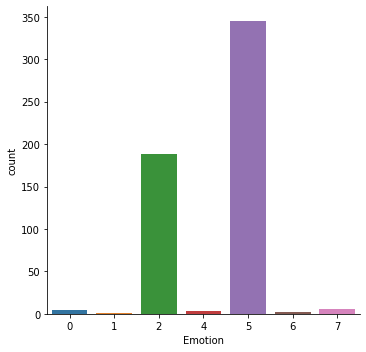

In [57]:
sns.catplot(x="Emotion", data=data[data["Origin"] == "AirBnb"][["Emotion"]], kind="count");

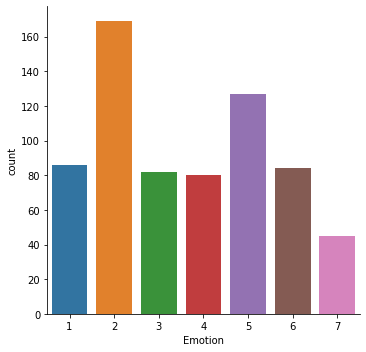

In [58]:
sns.catplot(x="Emotion", data=data[data["Origin"] == "NimStim"][["Emotion"]], kind="count");